In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,HistGradientBoostingRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_validate
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import altair as alt

%load_ext autoreload
%autoreload 2

def save(model, filename='bestmodel.pickle'):
    with open('output/'+filename, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

def save_feature_selection(cols, filename='feat_selection.pickle'):
    with open('output/'+filename, 'wb') as handle:
        pickle.dump(cols, handle, protocol=pickle.HIGHEST_PROTOCOL)

def submit(model):
    pred = model.predict(final_test)
    final_test['SalePrice'] = np.exp(pred)
    final_test[['Id','SalePrice']].to_csv('output/submission.csv', index=False)

## Import data

In [3]:
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)

In [4]:
from sklearn.preprocessing import LabelEncoder
ord_x = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

In [5]:
def inv_y(transformed_y):
    return np.exp(transformed_y)


## Make preprocessing pipelines

In [6]:
from sklearn.impute import SimpleImputer
# todo multivariate imputation, possibly with pipelines for numeric and categorical data

from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
# https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
# https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler/51237727
# don't know features are normal so just going with minmax scalar atm

from sklearn.preprocessing import OneHotEncoder
#https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki
#The crux of it is that the sklearn encoder creates a function which persists and can then be applied to new data sets which use the same categorical variables, with consistent results.
# So don't use pandas get dummies, but a OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

numeric_transformer = Pipeline(steps=[
    ('impute_num', SimpleImputer(strategy='median')),
    ('scale_num', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('impute_cat', SimpleImputer(strategy='most_frequent')),
    # ('label_encode', preprocessing.LabelEncoder()),
    ('onehot_cat', OneHotEncoder(handle_unknown="ignore"))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, num_x),
        ('category', categorical_transformer, cat_x)])


def densify(x): # needs to use a function, lambda gives problems with pickling
    return x.todense()


In [7]:
class Decorator(object):
    def __init__(self, arg):
        self.arg = arg
    def __call__(self, cls):
        class Wrapped(cls):
            classattr = self.arg
            def transform(self, value):
                return value * 2
        return Wrapped

from utils.sklearn_custom_steps import DFSimpleImputer, DFOneHotEncoder,DFMinMaxScaler,DFColumnTransformer

In [8]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import make_column_selector

def get_pipeline(model, outlier = False, impute=True,scale=True,onehot=True,label=False,to_dense=False):
    if outlier:
        print('outlier removal not implemented yet')
        return
    cat_steps = []
    if impute: cat_steps.append(('impute_cat', DFSimpleImputer(strategy='most_frequent')))
    # if impute: cat_steps.append(('impute_cat', IterativeImputer(max_iter=10, random_state=0)))
    if label: cat_steps.append(('label_encode', preprocessing.LabelEncoder()))
    if onehot: cat_steps.append(('onehot_cat', DFOneHotEncoder(handle_unknown="ignore")))
    # cat_steps.append(('to_pandas_cat', To_Pandas(cat_x)))
    categorical_transformer = Pipeline(steps=cat_steps)

    num_steps = []
    if impute: num_steps.append(('impute_num', DFSimpleImputer(strategy='mean')))
    # if impute: num_steps.append(('impute_num', IterativeImputer(max_iter=10, random_state=0)))
    if scale: num_steps.append(('scale_num', DFMinMaxScaler()))
    # num_steps.append(('to_pandas_num', To_Pandas(num_x)))
    numeric_transformer = Pipeline(steps=num_steps)

    preprocessor = DFColumnTransformer(transformers=[
        ('numeric', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('category', categorical_transformer, make_column_selector(dtype_exclude=np.number)),
        # ('labeling',LabelEncoder(),ord_x)
        ])

    final_pipe = [('preprocess', preprocessor)]
    if to_dense: final_pipe.append(('to_dense',FunctionTransformer(densify, accept_sparse=True)))
    final_pipe.append(('model',model))

    return Pipeline(steps=final_pipe)
    

## Collection of models with hyperparameters

In [9]:
from utils.model_hyperparameters import models
models.keys()

dict_keys(['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet', 'svm.SVR', 'KNeighborsRegressor', 'RandomForestRegressor', 'AutoCatBoostRegressor', 'xgb.XGBRegressor', 'lgb.LGBMRegressor', 'HistGradientBoostingRegressor', 'GradientBoostingRegressor', 'LassoCV', 'MLPRegressor'])

## Rough test of all models

In [10]:
def cross_val_models(to_test):
    for name in to_test:
        pipe = get_pipeline(models[name].model, **models[name].preprocess)
        # score = -1 * cross_val_score(pipe, train_x, train_y,cv=3,scoring='neg_root_mean_squared_error')
        # below is necessary for looking at train scores
        num_fold = 5
        scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
        # scoring is identical to 
        # make_scorer(mean_squared_error,greater_is_better=False, root=False,squared=False)
        # neg_mean_squared_log_error
        print(f"{name:<30}train {-1 * sum(scores['train_score'])/num_fold:.5f}, test {-1 * sum(scores['test_score'])/num_fold:.5f}")

# def test_model(model):
#         num_fold = 5
#         pipe = get_pipeline(model)
#         scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
#         print(f"train {-1 * sum(scores['train_score'])/num_fold:.3f}, test {-1 * sum(scores['test_score'])/num_fold:.3f}")
#         return pipe

def test_model(model,train_x = train_x,param=None):
    print(train_x.shape)

    num_fold = 5
    if not param: param = {}
    pipe = get_pipeline(model,**param)
    scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
    print(f"test {-1 * sum(scores['test_score'])/num_fold:.7f}, train {-1 * sum(scores['train_score'])/num_fold:.7f}")
    return pipe

In [68]:
cross_val_models(models)

LinearRegression              train 0.09870, test 45843221919.01426
Lasso                         train 0.39044, test 0.39034


KeyboardInterrupt: 

## Tune number of iterations for Catboost

In [29]:
model = models['CatBoostRegressor'].model
pipe = test_model(model, models['CatBoostRegressor'].preprocess)
fitted = pipe.named_steps['model'].fit(pipe[:-1].transform(train_x[:1000]),train_y[:1000],eval_set=(
    pipe[:-1].transform(train_x[1000:]),train_y[1000:]))

In [30]:
fits = {}
fits['learn'] = list(fitted.get_evals_result()['learn'].values())[0]
fits['validation'] = list(fitted.get_evals_result()['validation'].values())[0]
df = pd.DataFrame.from_dict(fits)
df.reset_index(inplace=True)
df =  df.melt('index',var_name= 'type',value_name='score')
fitted.get_evals_result()

alt.Chart(df).mark_line().encode(
    x='index',
    y='score',
    color='type',
)

alt.Chart(...)

## Hyperparameter tuning

In [127]:
from skopt import BayesSearchCV, callbacks
from skopt.space import Real, Categorical, Integer

TRAIN_TIME = 600
NUM_ITERATIONS = 150
NO_IMPROVEMENT_STOP_THRES = 25

def gen_opt_settings(model_name):
    model = {'model': [models[model_name].model]}
    for k,v in models[model_name].hyper.items():
        model['model__'+k] = v
    return (model, NUM_ITERATIONS)

def optimize_model(model_name):
    print('running', model_name)
    def no_improvement_detector(optim_result):
        score = opt.best_score_
        # print(optim_result.x)
        print(f"{'best score':15}{score}")
        if score > opt.train_status['current_score']:
            opt.train_status['current_score'] = score
            opt.train_status['not_improving'] = 0
        else:
            opt.train_status['not_improving'] += 1
            if opt.train_status['not_improving'] == opt.train_status['stop_thres']: return True
    checkpointsaver = callbacks.CheckpointSaver("output/" + model_name + "_skopt.pkl")
    deadlinestopper = callbacks.DeadlineStopper(TRAIN_TIME)

    opt = BayesSearchCV(
        get_pipeline(models[model_name].model, **models[model_name].preprocess),
        [gen_opt_settings(model_name)],
        cv=5, 
        scoring = 'neg_root_mean_squared_error',
        return_train_score = True,
        random_state = 112 
        )
    opt.train_status = { 'current_score': -100, 'not_improving': 0, 'stop_thres' :NO_IMPROVEMENT_STOP_THRES}

    opt.fit(train_x[cols],train_y, callback = [no_improvement_detector,checkpointsaver,deadlinestopper])
    return opt

def hashing(self): return 8398398478478 
CatBoostRegressor.__hash__ = hashing

to_test = [k for k in models]
to_test = [
    # 'svm.SVR',
    'ElasticNet',
    'RandomForestRegressor',
    'AutoCatBoostRegressor',
    'xgb.XGBRegressor',
    'lgb.LGBMRegressor',
    'GradientBoostingRegressor']

results = {}
for name in to_test:
    results[name] = optimize_model(name)

running ElasticNet
best score     -0.2546370655491259
best score     -0.10760246639871549
best score     -0.10703960466527584
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score     -0.10646960886702872
best score

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=85]="RL": Cannot convert 'b'RL'' to float

In [16]:
#summarize tuning results
for model in results:
    best_run = results[model].cv_results_['rank_test_score'].index(1)
    mean_test_score = -1 * results[model].cv_results_['mean_test_score'][best_run]
    std_test_score = results[model].cv_results_['std_test_score'][best_run]
    mean_train_score = -1 * results[model].cv_results_['mean_train_score'][best_run]
    mean_score_time = results[model].cv_results_['mean_score_time'][best_run]
    best_params = results[model].best_params_

    # print(f"{model:<30} Best score {mean_test_score:.4f} std {std_test_score:.4f} train {mean_train_score:.4f} time {mean_score_time:.4f}")
    print(f"{model:<30} Best score {mean_test_score:.4f} std {std_test_score:.4f} train {mean_train_score:.4f} time {mean_score_time:.4f}")

ElasticNet                     Best score 0.1076 std 0.0057 train 0.0946 time 0.0552
RandomForestRegressor          Best score 0.1314 std 0.0047 train 0.0522 time 0.0634
CatBoostRegressor              Best score 0.1174 std 0.0036 train 0.0809 time 0.0574
xgb.XGBRegressor               Best score 0.1127 std 0.0050 train 0.0757 time 0.0324
lgb.LGBMRegressor              Best score 0.1142 std 0.0053 train 0.0726 time 0.0264


In [13]:
# Assert to see if it matches the BayesSearchCV results. Not necessary since it matches
for model in results:
    pipe = results[model].best_estimator_
    num_fold = 5
    scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
    print(f"{model:<30}train {-1 * sum(scores['train_score'])/num_fold:.4f}, test {-1 * sum(scores['test_score'])/num_fold:.4f}")


svm.SVR                       train 0.0961, test 0.1163
ElasticNet                    train 0.0956, test 0.1080
RandomForestRegressor         train 0.0504, test 0.1306
CatBoostRegressor             train 0.0810, test 0.1189
xgb.XGBRegressor              train 0.0796, test 0.1132
lgb.LGBMRegressor             train 0.0734, test 0.1139


## Experimental runs

In [101]:
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)
model = test_model(Ridge())

(1414, 177)
final shape (1131, 316)
final shape (283, 316)
final shape (1131, 316)
final shape (1131, 316)
final shape (283, 316)
final shape (1131, 316)
final shape (1131, 315)
final shape (283, 315)
final shape (1131, 315)
final shape (1131, 315)
final shape (283, 315)
final shape (1131, 315)
final shape (1132, 311)
final shape (282, 311)
final shape (1132, 311)
test 0.1156128, train 0.0882743


In [51]:
model = test_model(LassoCV(),train_x=train_x[cols])

test nan, train nan


In [52]:
train_x[cols]

,YearBuilt,OverallCond,BsmtFinSF1_log,MSZoning,Neighborhood,OverallQual_2,OverallGrade,OverallQual,GarageYrBlt,AllPorchSF,...,AllFlrsSF_2,SimplOverallCond,TotalBath_sq,WoodDeckSF,SimplOverallQual,BsmtQual,BsmtUnfSF_log,KitchenQual_sq,TotalBsmtSF_log,GarageArea_log
0,2003,5,6.561031,RL,CollgCr,49,35,7,2003.0,61,...,2924100,2,1.870829,0,3,4.0,5.017280,2.000000,6.753438,6.308098
1,1976,8,6.886532,RL,Veenker,36,48,6,1976.0,0,...,1592644,3,1.581139,298,2,4.0,5.652489,1.732051,7.141245,6.133398
2,2001,5,6.188264,RL,CollgCr,49,35,7,2001.0,42,...,3189796,2,1.870829,0,3,4.0,6.075346,2.000000,6.825460,6.411818
3,1915,5,5.379897,RL,Crawfor,49,35,7,1998.0,307,...,2948089,2,1.414214,0,3,3.0,6.293419,2.000000,6.629363,6.466145
4,2000,5,6.486161,RL,NoRidge,64,40,8,2000.0,84,...,4831204,2,1.870829,192,3,4.0,6.196444,2.000000,7.044033,6.729824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2004,5,6.018593,FV,Somerst,49,35,7,2004.0,113,...,1490841,2,1.732051,0,3,4.0,6.699500,2.000000,7.108244,5.993961
1455,1999,5,0.000000,RL,Gilbert,36,30,6,1999.0,40,...,2712609,2,1.581139,0,2,4.0,6.860664,1.732051,6.860664,6.133398
1456,1978,6,6.673298,RL,NWAmes,36,36,6,1978.0,0,...,4297329,2,1.732051,349,2,4.0,6.380123,1.732051,7.341484,6.216606
1458,1950,6,3.912023,RL,NAmes,25,30,5,1950.0,112,...,1162084,2,1.414214,366,2,3.0,0.000000,2.000000,6.983790,5.484797


## Stacking best models from hyperparam

In [29]:
from sklearn.ensemble import StackingRegressor

to_stack_list = [
    'ElasticNet',
    'RandomForestRegressor',
    'CatBoostRegressor',
    'xgb.XGBRegressor',
    'lgb.LGBMRegressor']

to_stack = [(model_name, results[model_name].best_estimator_) for model_name in to_stack_list]

model = StackingRegressor(to_stack, final_estimator = LinearRegression(), passthrough = False)
num_fold = 5
scores = cross_validate(model, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
print(f"stacking model train {-1 * sum(scores['train_score'])/num_fold:.4f}, test {-1 * sum(scores['test_score'])/num_fold:.4f}")

stacking model train nan, test nan


In [21]:
num_fold = 5

print(f"stacking model train {-1 * sum(scores['train_score'])/num_fold:.4f}, test {-1 * sum(scores['test_score'])/num_fold:.4f}")


stacking model train 0.0831, test 0.1062


In [ ]:
b

## Saving

In [24]:
train_info = (train_x, train_y, num_x, cat_x)
with open('output/train_info.pickle', 'wb') as handle:
    pickle.dump(train_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
model = get_pipeline(CatBoostRegressor(silent=True,cat_features=cat_x),onehot=False)
model = model.fit(train_x,train_y)
submit(model)
save(model,'lasso.pickle')

In [10]:
save(model,'model_catboostvanilla')

## FastAI

In [8]:
import fastai2
from fastai2.tabular.all import *
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)
df = train_x
df['SalePrice'] = train_y

In [9]:
dls = TabularDataLoaders.from_df(df, path='bla', y_names="SalePrice",
    cat_names = cat_x,
    cont_names = num_x,
    procs = [Categorify, FillMissing, Normalize])

In [10]:
learn = tabular_learner(dls, layers=[1000,500], loss_func=F.mse_loss, # or func MSELossFlat()
                        config=tabular_config(ps=[0.001,0.01], embed_p=0.04), 
                        metrics=rmse)

learn = tabular_learner(dls, loss_func=MSELossFlat(), 
                        metrics=rmse)

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=6.309573450380412e-07)

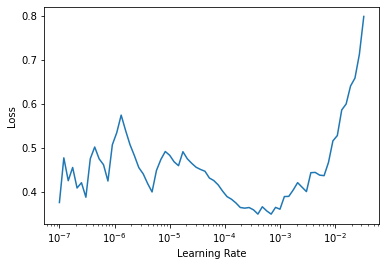

In [17]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(5, 6.918309954926372e-05, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,0.464082,0.127581,0.357185,00:02
1,0.447364,0.127885,0.357610,00:01
2,0.344326,0.136341,0.369243,00:01
3,0.307799,0.147011,0.383420,00:01
4,0.306841,0.133865,0.365875,00:01


In [20]:
final_test['BsmtFinSF1'] = final_test['BsmtFinSF1'].fillna(0)
final_test['BsmtFinSF2'] = final_test['BsmtFinSF2'].fillna(0)
final_test['BsmtUnfSF'] = final_test['BsmtUnfSF'].fillna(0)
final_test['TotalBsmtSF'] = final_test['TotalBsmtSF'].fillna(0)
final_test['BsmtFullBath'] = final_test['BsmtFullBath'].fillna(0)
final_test['KitchenQual'] = final_test['KitchenQual'].fillna(train_x['KitchenQual'].mean())
final_test['Functional'] = final_test['Functional'].fillna(train_x['Functional'].mean())
final_test['GarageCars'] = final_test['GarageCars'].fillna(0)
final_test['GarageArea'] = final_test['GarageArea'].fillna(0)
final_test['SimplFunctional'] = final_test['SimplFunctional'].fillna(0)
final_test['SimplKitchenQual'] = final_test['SimplKitchenQual'].fillna(0)
final_test['KitchenScore'] = final_test['KitchenScore'].fillna(0)
final_test['SimplFunctional'] = final_test['SimplFunctional'].fillna(train_x['SimplFunctional'].mean())
final_test['SimplKitchenScore'] = final_test['SimplKitchenScore'].fillna(train_x['SimplKitchenScore'].mean())
final_test['TotalBath'] = final_test['TotalBath'].fillna(1)
final_test['AllSF'] = final_test['AllSF'].fillna(train_x['AllSF'].mean())
final_test['AllSF_2'] = final_test['AllSF_2'].fillna(train_x['AllSF_2'].mean())
final_test['AllSF_3'] = final_test['AllSF_3'].fillna(train_x['AllSF_3'].mean())
final_test['AllSF_sq'] = final_test['AllSF_sq'].fillna(train_x['AllSF_sq'].mean())
final_test['GarageCars_2'] = final_test['GarageCars_2'].fillna(train_x['GarageCars_2'].mean())
final_test['GarageCars_3'] = final_test['GarageCars_3'].fillna(train_x['GarageCars_3'].mean())
final_test['GarageCars_sq'] = final_test['GarageCars_sq'].fillna(train_x['GarageCars_sq'].mean())
final_test['TotalBath_2'] = final_test['TotalBath_2'].fillna(train_x['TotalBath_2'].mean())
final_test['TotalBath_3'] = final_test['TotalBath_3'].fillna(train_x['TotalBath_3'].mean())
final_test['TotalBath_sq'] = final_test['TotalBath_sq'].fillna(train_x['TotalBath_sq'].mean())
final_test['TotalBath_sq'] = final_test['TotalBath_sq'].fillna(train_x['TotalBath_sq'].mean())
final_test['KitchenQual_2'] = final_test['KitchenQual_2'].fillna(train_x['KitchenQual_2'].mean())
final_test['KitchenQual_3'] = final_test['KitchenQual_3'].fillna(train_x['KitchenQual_3'].mean())
final_test['KitchenQual_sq'] = final_test['KitchenQual_sq'].fillna(train_x['KitchenQual_sq'].mean())
final_test['BsmtFinSF1_log'] = final_test['BsmtFinSF1_log'].fillna(train_x['BsmtFinSF1_log'].mean())
final_test['BsmtFinSF2_log'] = final_test['BsmtFinSF2_log'].fillna(train_x['BsmtFinSF2_log'].mean())
final_test['BsmtUnfSF_log'] = final_test['BsmtUnfSF_log'].fillna(train_x['BsmtUnfSF_log'].mean())
final_test['TotalBsmtSF_log'] = final_test['TotalBsmtSF_log'].fillna(train_x['TotalBsmtSF_log'].mean())
final_test['BsmtFullBath_log'] = final_test['BsmtFullBath_log'].fillna(train_x['BsmtFullBath_log'].mean())
final_test['TotalBsmtSF_log'] = final_test['TotalBsmtSF_log'].fillna(train_x['TotalBsmtSF_log'].mean())
final_test['BsmtHalfBath_log'] = final_test['BsmtHalfBath_log'].fillna(train_x['BsmtHalfBath_log'].mean())
final_test['GarageCars_log'] = final_test['GarageCars_log'].fillna(train_x['GarageCars_log'].mean())
final_test['GarageArea_log'] = final_test['GarageArea_log'].fillna(train_x['GarageArea_log'].mean())
final_test['AllSF_log'] = final_test['AllSF_log'].fillna(train_x['AllSF_log'].mean())
final_test['BsmtHalfBath'] = final_test['BsmtHalfBath'].fillna(train_x['BsmtHalfBath'].mean())

# test_to = to.new(final_test)
# test_to.process()

In [21]:
final_test['MiscFeature']=np.nan
dl = learn.dls.test_dl(final_test)
res= learn.get_preds(dl=dl)

In [22]:
final_test['SalePrice'] = np.exp(res[0].numpy())
final_test[['Id','SalePrice']].to_csv('output/submission.csv', index=False)

In [23]:
final_test['SalePrice'][:100]

0      85427.546875
1        253.119598
2     104106.257812
3      92326.226562
4     149614.921875
          ...      
95     57966.574219
96     76293.351562
97     73702.171875
98     66336.664062
99     92849.398438
Name: SalePrice, Length: 100, dtype: float32

In [24]:
final_test['SalePrice'].describe()

count    1.459000e+03
mean     1.222441e+05
std      9.191402e+04
min      1.197349e+00
25%      7.746236e+04
50%      1.007307e+05
75%      1.361005e+05
max      1.448536e+06
Name: SalePrice, dtype: float64

## Borutashap for feature selection

https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677

In [24]:
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)

from BorutaShap import BorutaShap
from utils.model_hyperparameters import AutoCatBoostRegressor
cat = CatBoostRegressor(max_depth=5,silent=True)
pipe = get_pipeline(BorutaShap(model = cat, importance_measure='shap',
                              classification=False),onehot=False)

In [25]:
feat_selector = pipe.fit(train_x,train_y,model__n_trials=100)

100%|██████████| 100/100 [1:26:57<00:00, 52.17s/it]48 75 48 (accept,tentative,reject)
48 attributes confirmed important: ['AllSF', 'YearRemodAdd', 'BsmtExposure', 'OverallGrade', 'CentralAir', 'AllSF_log', 'AllFlrsSF_3', 'YearBuilt', 'OverallQual_3', 'AllSF_3', 'OverallQual_2', 'GarageYrBlt', 'AllSF_sq', 'TotalBath_3', 'KitchenQual_2', 'AllFlrsSF_2', 'GrLivArea_sq', 'GrLivArea', 'BsmtQual', 'SimplOverallQual', 'SimplOverallQual_2', 'OverallQual', 'TotalBath_2', 'BsmtFinSF1_log', 'LotArea_log', 'KitchenQual_sq', 'MSZoning', 'BsmtFinSF1', 'YearRemodAdd_log', 'AllFlrsSF_sq', 'GarageFinish', 'BsmtFinType1', 'LotArea', 'Fireplaces', 'Functional', 'GarageCars', 'Neighborhood', 'TotalBath_sq', 'AllPorchSF', 'Condition1', 'TotalBsmtSF_log', 'SaleCondition', 'OverallQual_sq', 'Fireplaces_log', 'KitchenQual', 'AllSF_2', 'OverallCond', 'TotalBath']
102 attributes confirmed unimportant: ['2ndFlrSF', 'LandContour', 'SimplExterGrade', 'MasVnrArea', 'ExterQual', 'SaleType', 'LowQualFinSF', 'KitchenAb

In [26]:
cols = {'all':train_x.columns,
        'selected':feat_selector.named_steps['model'].accepted + feat_selector.named_steps['model'].tentative,
        'accepted':feat_selector.named_steps['model'].accepted,
        'tentative':feat_selector.named_steps['model'].tentative,
        'rejected':feat_selector.named_steps['model'].rejected}
def save_feature_selection(cols, filename='feat_selection.pickle'):
    with open('output/'+filename, 'wb') as handle:
        pickle.dump(cols, handle, protocol=pickle.HIGHEST_PROTOCOL)
save_feature_selection(cols)


In [28]:
cols['rejected']

['2ndFlrSF',
 'LandContour',
 'SimplExterGrade',
 'MasVnrArea',
 'ExterQual',
 'SaleType',
 'LowQualFinSF',
 'KitchenAbvGr_log',
 '3SsnPorch_log',
 'MasVnrArea_log',
 'HeatingQC',
 'RoofMatl',
 'KitchenAbvGr',
 'BsmtFinSF2_log',
 'SimplGarageScore',
 'SimplKitchenScore',
 'OpenPorchSF',
 'WoodDeckSF_log',
 'SimplPoolQC',
 'has2ndfloor',
 'MiscVal_log',
 'Foundation',
 'hasgarage',
 'SimplOverallGrade',
 '2ndFlrSF_log',
 'GarageCond',
 'HasMasVnr',
 'PoolArea',
 'OpenPorchSF_log',
 'TotRmsAbvGrd_log',
 '1stFlrSF_log',
 'haspool',
 'SimplKitchenQual',
 'SimplFireplaceQu',
 'BsmtFinType2',
 'BoughtOffPlan',
 'LotFrontage_log',
 'ScreenPorch',
 'EnclosedPorch_log',
 'BsmtFullBath_log',
 'ExterGrade',
 'GarageType',
 'Exterior2nd',
 'HouseStyle',
 'Alley',
 'PoolQC',
 'hasbsmt',
 'FullBath',
 'PoolScore',
 'Street',
 'SimplBsmtFinType2',
 'GarageScore_2',
 'BsmtCond',
 'MiscVal',
 'BsmtHalfBath',
 'BsmtFullBath',
 'SimplHeatingQC',
 'BldgType',
 'BsmtFinSF2',
 'SimplGarageQual',
 'Exterior1st',
 'MSSubClass',
 'MiscFeature',
 'GarageScore_sq',
 'SimplFireplaceScore',
 'Fence',
 'GarageGrade',
 'PavedDrive',
 'EnclosedPorch',
 'MasVnrType',
 'BsmtHalfBath_log',
 'TotRmsAbvGrd',
 'FullBath_log',
 'WoodDeckSF',
 'SimplGarageCond',
 'LotShape',
 'SimplExterCond',
 'RoofStyle',
 'MoSold',
 'BedroomAbvGr',
 'YrSold',
 'Condition2',
 'Heating',
 'BedroomAbvGr_log',
 'ExterQual_sq',
 'SimplBsmtCond',
 'LotConfig',
 'SimplPoolScore',
 'ScreenPorch_log',
 'HalfBath',
 'Electrical',
 'ExterCond',
 'LowQualFinSF_log',
 'KitchenScore',
 'HalfBath_log',
 'GarageScore_3',
 'SimplFunctional',
 'SimplExterQual',
 'PoolArea_log',
 'FireplaceQu',
 'LandSlope',
 '3SsnPorch']

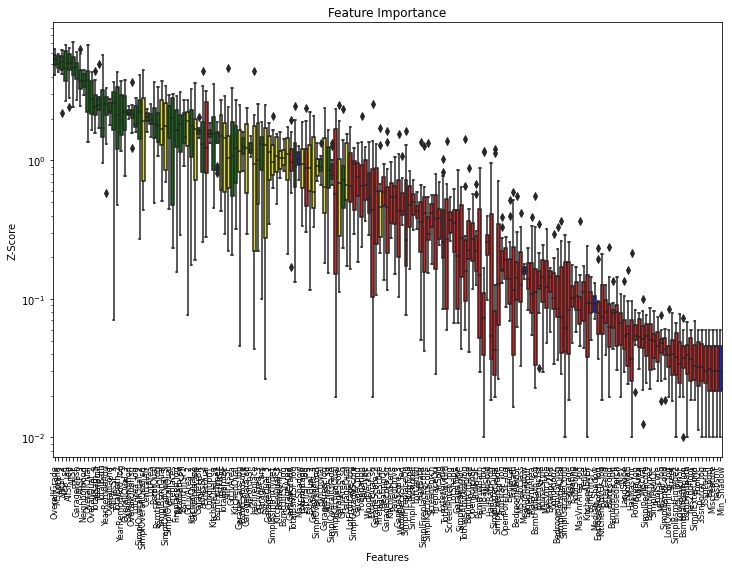

In [27]:
feat_selector.named_steps['model'].plot(which_features='all', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

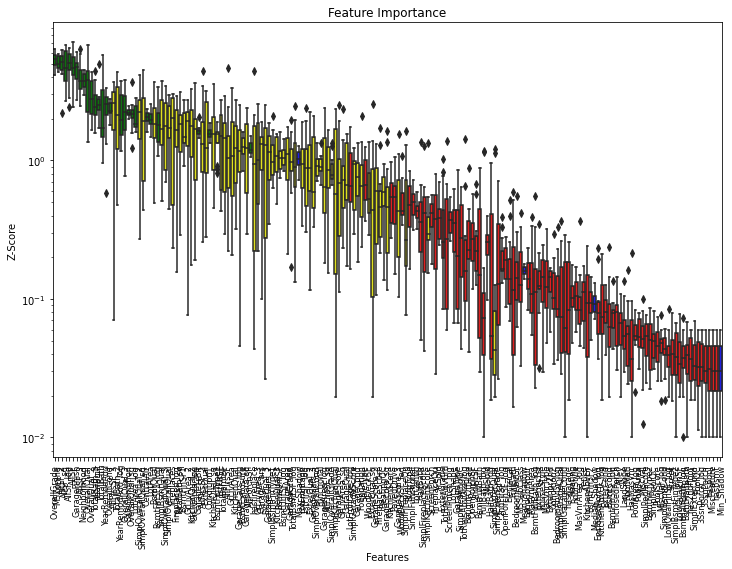

In [29]:
feat_selector.named_steps['model'].plot(which_features='all', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

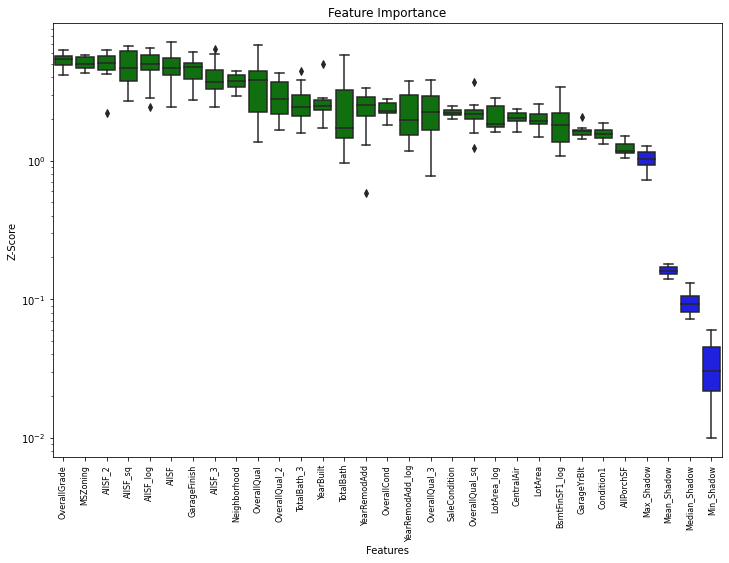

In [31]:
feat_selector.named_steps['model'].plot(which_features='accepted', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

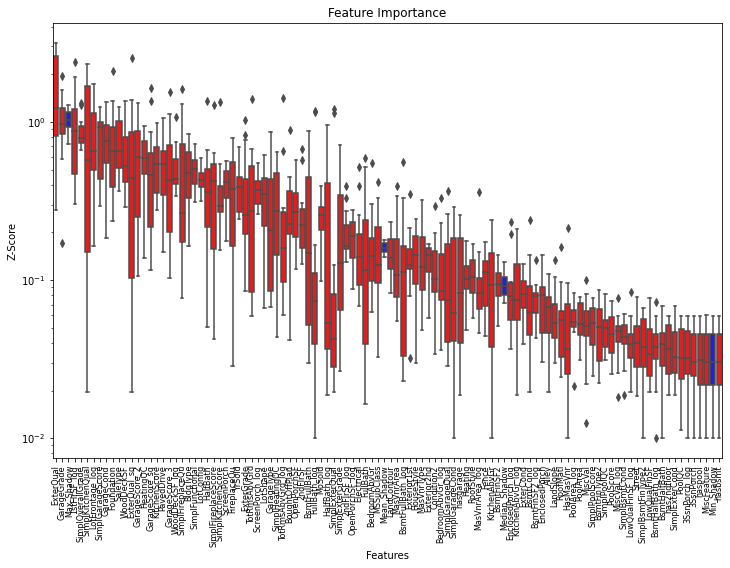

In [32]:
feat_selector.named_steps['model'].plot(which_features='rejected', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

In [31]:
cols = feat_selector.named_steps['model'].Subset(tentative=False).columns
res = test_model(get_pipeline(LassoCV()),train_x=train_x[cols])

(1414, 48)
test 0.1080971, train 0.1014069


In [30]:
cols = feat_selector.named_steps['model'].Subset(tentative=True).columns
res = test_model(get_pipeline(LassoCV()),train_x=train_x[cols])
# test 0.1064973, train 0.0978306

(1414, 75)
test 0.1075846, train 0.0999900


In [126]:
res = test_model(get_pipeline(LassoCV()),train_x=train_x)

(1414, 177)
test 0.1082112, train 0.0959171


In [33]:
with open('output/'+'res', 'wb') as handle:
        pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
f = open("output/res","rb")
res = pickle.load(f)